In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


Matplotlib is building the font cache; this may take a moment.


## Preprocessing the dataset for LSTM model:

In [2]:
#Load the dataset and create a dictionary to map user and product IDs to unique integer values
data = pd.read_csv('filtered_data.csv')
users = data['userId'].unique()
user_id_to_int = {user_id: i for i, user_id in enumerate(users)}

products = data['productId'].unique()
product_id_to_int = {product_id: i for i, product_id in enumerate(products)}


In [3]:
#Replace user and product IDs in the dataset with their corresponding integer values:
data['userId'] = data['userId'].apply(lambda x: user_id_to_int[x])
data['productId'] = data['productId'].apply(lambda x: product_id_to_int[x])


In [4]:
#Normalize the timestamp by subtracting the user's first ever review time:
data['timestamp'] = data.groupby('userId')['timestamp'].apply(lambda x: x - x.min())
data.head()

,userId,productId,rating,timestamp
0,0,0,5.0,16675200
1,1,0,1.0,0
2,2,0,3.0,120096000
3,3,0,2.0,7430400
4,4,0,1.0,0


In [5]:
#Split the dataset into training and testing sets
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Scale 'timestamp' to be between 0 and 1
scaler = MinMaxScaler()
train_df['timestamp'] = scaler.fit_transform(train_df['timestamp'].values.reshape(-1, 1))
val_df['timestamp'] = scaler.transform(val_df['timestamp'].values.reshape(-1, 1))

# Split the data into input and output variables
train_data = train_df.drop('rating', axis=1).values
train_labels = train_df['rating'].values
val_data = val_df.drop('rating', axis=1).values
val_labels = val_df['rating'].values

# Reshape the input variables for LSTM
train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
val_data = val_data.reshape((val_data.shape[0], val_data.shape[1], 1))


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Define and train the model: 

In [7]:
# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(128, input_shape=(train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the LSTM model
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Train the LSTM model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_data, train_labels, epochs=10, batch_size=64, validation_data=(val_data, val_labels), callbacks=[early_stop])


Epoch 1/10
24895/24895 [==============================] - 88s 4ms/step - loss: 1.5264 - mae: 0.9658 - val_loss: 1.4525 - val_mae: 0.9376
Epoch 2/10
24895/24895 [==============================] - 87s 3ms/step - loss: 1.4594 - mae: 0.9457 - val_loss: 1.4515 - val_mae: 0.9430
Epoch 3/10
24895/24895 [==============================] - 87s 3ms/step - loss: 1.4536 - mae: 0.9446 - val_loss: 1.4514 - val_mae: 0.9435
Epoch 4/10
24895/24895 [==============================] - 87s 3ms/step - loss: 1.4527 - mae: 0.9444 - val_loss: 1.4524 - val_mae: 0.9385
Epoch 5/10
24895/24895 [==============================] - 87s 3ms/step - loss: 1.4526 - mae: 0.9443 - val_loss: 1.4521 - val_mae: 0.9398
Epoch 6/10
24895/24895 [==============================] - 87s 3ms/step - loss: 1.4526 - mae: 0.9443 - val_loss: 1.4520 - val_mae: 0.9434
Epoch 7/10
24895/24895 [==============================] - 87s 3ms/step - loss: 1.4525 - mae: 0.9442 - val_loss: 1.4515 - val_mae: 0.9425
Epoch 8/10
24895/24895 [=================

## Evaluate the model:

In [8]:
#Prepare the Test Data
test_data = val_df.drop('rating', axis=1).values
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], 1))

In [9]:
# Use the trained LSTM model to make predictions on the test data
predictions = model.predict(test_data)

In [10]:
# Save the trained LSTM model
model.save('amazon_reviews_lstm_model.h5')

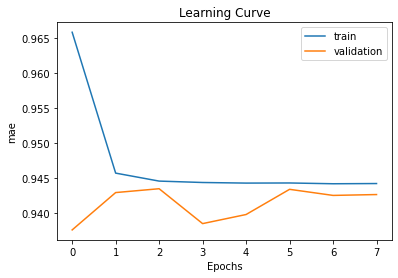

In [18]:
#Print the learning curve for each Epoch
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='validation')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

In [17]:
# Evaluate the performance of the LSTM model on the test data
rmse, mae = model.evaluate(test_data, val_df['rating'].values)
print('Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)


12448/12448 [==============================] - 14s 1ms/step - loss: 1.4514 - mae: 0.9433
Mean Squared Error: 1.4514108896255493
Mean Absolute Error: 0.9433237910270691
